In [2]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB7


In [10]:

# Set the paths to your train, test, and validation directories
train_dir = "final_dataset/train"
test_dir = "final_dataset/test"
val_dir = "final_dataset/validation"

# Define the image size and number of classes
image_size = (600, 600)  # Adjust image size based on the requirements
num_classes = 101

# Create data generators with data augmentation for the train set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.35,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical"
)

# Create data generators for the test and validation sets (no data augmentation)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical",
    shuffle=False  # Do not shuffle test data for evaluation
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical"
)


Found 75750 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


In [4]:
# Load the pre-trained EfficientNetB7 model (include_top=False to exclude classification layers)
base_model = EfficientNetB7(
    include_top=False,  # Exclude the top (output) layer
    weights='imagenet',  # Load pre-trained weights
    input_shape=(600, 600, 3)  # Specify input shape (adjust based on your requirements)
)

# Fine-tune the model by making some layers trainable
for layer in base_model.layers[:-38]:  # Fine-tune the last 100 layers
    layer.trainable = True
for layer in base_model.layers[-38:]:
    layer.trainable = False # You can set specific layers to trainable or not

# Add custom classification layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(101, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 600, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 600, 600, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 600, 600, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              

                                                                                                  
 block1c_dwconv (DepthwiseConv2  (None, 300, 300, 32  288        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 300, 300, 32  128        ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 300, 300, 32  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_s

 )                              2)                                                                
                                                                                                  
 block2a_activation (Activation  (None, 150, 150, 19  0          ['block2a_bn[0][0]']             
 )                              2)                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 192)         0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_s

 block2c_se_squeeze (GlobalAver  (None, 288)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 150, 150, 28  0           ['block2c_activation[0][0]',     
          

                                                                                                  
 block2e_se_squeeze (GlobalAver  (None, 288)         0           ['block2e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2e_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block2e_se_squeeze[0][0]']     
                                                                                                  
 block2e_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block2e_se_reshape[0][0]']     
                                                                                                  
 block2e_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block2e_se_reduce[0][0]']      
                                                                                                  
 block2e_s

 )                              8)                                                                
                                                                                                  
 block2g_se_squeeze (GlobalAver  (None, 288)         0           ['block2g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2g_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block2g_se_squeeze[0][0]']     
                                                                                                  
 block2g_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block2g_se_reshape[0][0]']     
                                                                                                  
 block2g_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block2g_se_reduce[0][0]']      
          

                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, 75, 75, 480)  0           ['block3b_activation[0][0]',     
                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_p

 block3d_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3d_se_reduce[0][0]']      
                                                                                                  
 block3d_se_excite (Multiply)   (None, 75, 75, 480)  0           ['block3d_activation[0][0]',     
                                                                  'block3d_se_expand[0][0]']      
                                                                                                  
 block3d_project_conv (Conv2D)  (None, 75, 75, 80)   38400       ['block3d_se_excite[0][0]']      
                                                                                                  
 block3d_project_bn (BatchNorma  (None, 75, 75, 80)  320         ['block3d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3d_d

 block3f_project_conv (Conv2D)  (None, 75, 75, 80)   38400       ['block3f_se_excite[0][0]']      
                                                                                                  
 block3f_project_bn (BatchNorma  (None, 75, 75, 80)  320         ['block3f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3f_drop (Dropout)         (None, 75, 75, 80)   0           ['block3f_project_bn[0][0]']     
                                                                                                  
 block3f_add (Add)              (None, 75, 75, 80)   0           ['block3f_drop[0][0]',           
                                                                  'block3e_add[0][0]']            
                                                                                                  
 block3g_e

 block4a_project_bn (BatchNorma  (None, 38, 38, 160)  640        ['block4a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, 38, 38, 960)  153600      ['block4a_project_bn[0][0]']     
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, 38, 38, 960)  3840       ['block4b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4b_expand_activation (Act  (None, 38, 38, 960)  0          ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block4d_expand_bn (BatchNormal  (None, 38, 38, 960)  3840       ['block4d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4d_expand_activation (Act  (None, 38, 38, 960)  0          ['block4d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4d_dwconv (DepthwiseConv2  (None, 38, 38, 960)  8640       ['block4d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4d_bn (BatchNormalization  (None, 38, 38, 960)  3840       ['block4d_dwconv[0][0]']         
 )        

                                                                                                  
 block4f_dwconv (DepthwiseConv2  (None, 38, 38, 960)  8640       ['block4f_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4f_bn (BatchNormalization  (None, 38, 38, 960)  3840       ['block4f_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4f_activation (Activation  (None, 38, 38, 960)  0          ['block4f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4f_s

 )                                                                                                
                                                                                                  
 block4h_activation (Activation  (None, 38, 38, 960)  0          ['block4h_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4h_se_squeeze (GlobalAver  (None, 960)         0           ['block4h_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4h_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4h_se_squeeze[0][0]']     
                                                                                                  
 block4h_s

 block4j_se_squeeze (GlobalAver  (None, 960)         0           ['block4j_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4j_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4j_se_squeeze[0][0]']     
                                                                                                  
 block4j_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4j_se_reshape[0][0]']     
                                                                                                  
 block4j_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4j_se_reduce[0][0]']      
                                                                                                  
 block4j_se_excite (Multiply)   (None, 38, 38, 960)  0           ['block4j_activation[0][0]',     
          

 block5b_se_excite (Multiply)   (None, 38, 38, 1344  0           ['block5b_activation[0][0]',     
                                )                                 'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 38, 38, 224)  301056      ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_project_bn (BatchNorma  (None, 38, 38, 224)  896        ['block5b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_drop (Dropout)         (None, 38, 38, 224)  0           ['block5b_project_bn[0][0]']     
                                                                                                  
 block5b_a

 block5d_project_conv (Conv2D)  (None, 38, 38, 224)  301056      ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 38, 38, 224)  896        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_drop (Dropout)         (None, 38, 38, 224)  0           ['block5d_project_bn[0][0]']     
                                                                                                  
 block5d_add (Add)              (None, 38, 38, 224)  0           ['block5d_drop[0][0]',           
                                                                  'block5c_add[0][0]']            
                                                                                                  
 block5e_e

 lization)                                                                                        
                                                                                                  
 block5f_drop (Dropout)         (None, 38, 38, 224)  0           ['block5f_project_bn[0][0]']     
                                                                                                  
 block5f_add (Add)              (None, 38, 38, 224)  0           ['block5f_drop[0][0]',           
                                                                  'block5e_add[0][0]']            
                                                                                                  
 block5g_expand_conv (Conv2D)   (None, 38, 38, 1344  301056      ['block5f_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5g_e

                                                                                                  
 block5h_add (Add)              (None, 38, 38, 224)  0           ['block5h_drop[0][0]',           
                                                                  'block5g_add[0][0]']            
                                                                                                  
 block5i_expand_conv (Conv2D)   (None, 38, 38, 1344  301056      ['block5h_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5i_expand_bn (BatchNormal  (None, 38, 38, 1344  5376       ['block5i_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5i_e

                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 38, 38, 1344  301056      ['block5j_add[0][0]']            
                                )                                                                 
                                                                                                  
 block6a_expand_bn (BatchNormal  (None, 38, 38, 1344  5376       ['block6a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6a_expand_activation (Act  (None, 38, 38, 1344  0          ['block6a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6a_d

 ization)                       )                                                                 
                                                                                                  
 block6c_expand_activation (Act  (None, 19, 19, 2304  0          ['block6c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 19, 19, 2304  57600      ['block6c_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block6c_bn (BatchNormalization  (None, 19, 19, 2304  9216       ['block6c_dwconv[0][0]']         
 )                              )                                                                 
          

 ivation)                       )                                                                 
                                                                                                  
 block6e_dwconv (DepthwiseConv2  (None, 19, 19, 2304  57600      ['block6e_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, 19, 19, 2304  9216       ['block6e_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block6e_activation (Activation  (None, 19, 19, 2304  0          ['block6e_bn[0][0]']             
 )                              )                                                                 
          

 D)                             )                                ']                               
                                                                                                  
 block6g_bn (BatchNormalization  (None, 19, 19, 2304  9216       ['block6g_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block6g_activation (Activation  (None, 19, 19, 2304  0          ['block6g_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6g_se_squeeze (GlobalAver  (None, 2304)        0           ['block6g_activation[0][0]']     
 agePooling2D)                                                                                    
          

 )                              )                                                                 
                                                                                                  
 block6i_activation (Activation  (None, 19, 19, 2304  0          ['block6i_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6i_se_squeeze (GlobalAver  (None, 2304)        0           ['block6i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6i_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6i_se_squeeze[0][0]']     
                                                                                                  
 block6i_s

 )                              )                                                                 
                                                                                                  
 block6k_se_squeeze (GlobalAver  (None, 2304)        0           ['block6k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6k_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6k_se_squeeze[0][0]']     
                                                                                                  
 block6k_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6k_se_reshape[0][0]']     
                                                                                                  
 block6k_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6k_se_reduce[0][0]']      
          

 agePooling2D)                                                                                    
                                                                                                  
 block6m_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6m_se_squeeze[0][0]']     
                                                                                                  
 block6m_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6m_se_reshape[0][0]']     
                                                                                                  
 block6m_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6m_se_reduce[0][0]']      
                                                                                                  
 block6m_se_excite (Multiply)   (None, 19, 19, 2304  0           ['block6m_activation[0][0]',     
                                )                                 'block6m_se_expand[0][0]']      
          

 block7b_se_excite (Multiply)   (None, 19, 19, 3840  0           ['block7b_activation[0][0]',     
                                )                                 'block7b_se_expand[0][0]']      
                                                                                                  
 block7b_project_conv (Conv2D)  (None, 19, 19, 640)  2457600     ['block7b_se_excite[0][0]']      
                                                                                                  
 block7b_project_bn (BatchNorma  (None, 19, 19, 640)  2560       ['block7b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_drop (Dropout)         (None, 19, 19, 640)  0           ['block7b_project_bn[0][0]']     
                                                                                                  
 block7b_a

 block7d_project_conv (Conv2D)  (None, 19, 19, 640)  2457600     ['block7d_se_excite[0][0]']      
                                                                                                  
 block7d_project_bn (BatchNorma  (None, 19, 19, 640)  2560       ['block7d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7d_drop (Dropout)         (None, 19, 19, 640)  0           ['block7d_project_bn[0][0]']     
                                                                                                  
 block7d_add (Add)              (None, 19, 19, 640)  0           ['block7d_drop[0][0]',           
                                                                  'block7c_add[0][0]']            
                                                                                                  
 top_conv 

In [93]:
def check_trainable_layers(model):
    trainable_layers = []
    frozen_layers = []
    
    for layer in model.layers:
        if layer.trainable:
            trainable_layers.append(layer.name)
        else:
            frozen_layers.append(layer.name)
    
    return trainable_layers, frozen_layers

# Call the function to check trainable and frozen layers
trainable_layers, frozen_layers = check_trainable_layers(model)

print("Trainable Layers:")
for layer in trainable_layers:
    print(layer)

print("\nFrozen Layers:")
for layer in frozen_layers:
    print(layer)


Trainable Layers:
global_average_pooling2d_14
dense_28
dense_29

Frozen Layers:
input_16
rescaling_15
normalization_15
tf.math.truediv_15
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block1c_dwconv
block1c_bn
block1c_activation
block1c_se_squeeze
block1c_se_reshape
block1c_se_reduce
block1c_se_expand
block1c_se_excite
block1c_project_conv
block1c_project_bn
block1c_drop
block1c_add
block1d_dwconv
block1d_bn
block1d_activation
block1d_se_squeeze
block1d_se_reshape
block1d_se_reduce
block1d_se_expand
block1d_se_excite
block1d_project_conv
block1d_project_bn
block1d_drop
block1d_add
block2a_expand_conv
block2a_exp

In [7]:
# Define Callbacks
checkpoint = ModelCheckpoint("efficientB7.h5", save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min', verbose=1)

# List of callbacks
callbacks_list = [checkpoint, early_stopping, reduce_lr]


In [95]:
import time
start_time = time.time()

In [11]:
# Train the model
history = model.fit(
    train_generator,  # Your training dataset
    validation_data=val_generator,  # Your validation dataset
    epochs=30,  # Adjust the number of epochs
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/30


2023-11-24 06:03:43.245914: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500


   1/4735 [..............................] - ETA: 15:17:13 - loss: 1.4415 - accuracy: 0.6250

2023-11-24 06:03:44.906243: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


  42/4735 [..............................] - ETA: 1:09:28 - loss: 0.7967 - accuracy: 0.7917

KeyboardInterrupt: 

In [97]:
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

Total training time: 134291.72 seconds


In [8]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('efficientB7.h5')

In [12]:
# Train the model
history2 = model.fit(
    train_generator,  # Your training dataset
    validation_data=val_generator,  # Your validation dataset
    epochs=30,  # Adjust the number of epochs
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/30
4735/4735 [==============================] - ETA: 0s - loss: 0.7741 - accuracy: 0.7855
Epoch 1: val_loss improved from inf to 0.78703, saving model to efficientB7.h5
4735/4735 [==============================] - 4537s 958ms/step - loss: 0.7741 - accuracy: 0.7855 - val_loss: 0.7870 - val_accuracy: 0.7879 - lr: 1.0000e-04
Epoch 2/30
4735/4735 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.7895
Epoch 2: val_loss did not improve from 0.78703
4735/4735 [==============================] - 4527s 956ms/step - loss: 0.7572 - accuracy: 0.7895 - val_loss: 0.7924 - val_accuracy: 0.7861 - lr: 1.0000e-04
Epoch 3/30
4735/4735 [==============================] - ETA: 0s - loss: 0.7504 - accuracy: 0.7914
Epoch 3: val_loss improved from 0.78703 to 0.78017, saving model to efficientB7.h5
4735/4735 [==============================] - 4470s 944ms/step - loss: 0.7504 - accuracy: 0.7914 - val_loss: 0.7802 - val_accuracy: 0.7924 - lr: 1.0000e-04
Epoch 4/30
4735/4735 [==========


KeyboardInterrupt



In [99]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")

474/474 [==============================] - 212s 447ms/step - loss: 0.8104 - accuracy: 0.7832
Test Loss: 0.8104
Test Accuracy: 78.32%


In [100]:
# Calculate metrics
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = [tf.argmax(pred).numpy() for pred in predictions]
y_true = test_generator.classes

474/474 [==============================] - 213s 442ms/step


In [101]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_true, y_pred)))
print("F1 Score: {:.2f}".format(f1_score(y_true, y_pred, average='macro')))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.58      0.63      0.61       150
         baby_back_ribs       0.72      0.81      0.76       150
                baklava       0.84      0.71      0.77       150
         beef_carpaccio       0.87      0.72      0.79       150
           beef_tartare       0.75      0.73      0.74       150
             beet_salad       0.72      0.71      0.71       150
               beignets       0.79      0.83      0.81       150
               bibimbap       0.89      0.92      0.90       150
          bread_pudding       0.70      0.56      0.62       150
      breakfast_burrito       0.65      0.85      0.74       150
             bruschetta       0.68      0.73      0.70       150
           caesar_salad       0.87      0.83      0.85       150
                cannoli       0.84      0.90      0.87       150
          caprese_salad       0.67      0.83      0.74       150
 

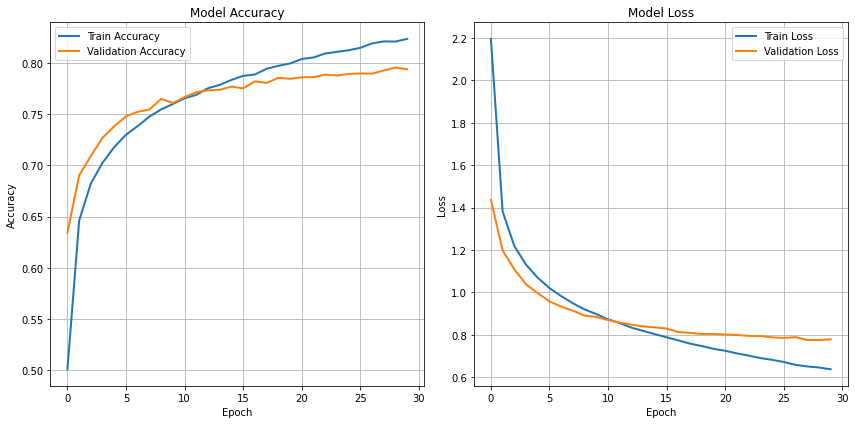

In [102]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()